# Predicting Newsletter Subscription from Player Age in a Minecraft Research Server


# Introduction:


provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and fully describe the dataset that was used to answer the question



# Methods: 

provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report

# Code:

In [13]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

Loading data into R by using link from github so it is reproducible:

In [14]:
players <- read_csv("https://raw.githubusercontent.com/calentynes/dsci_group_project/refs/heads/master/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/calentynes/dsci_group_project/refs/heads/master/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Combining two datasets together:

In [3]:
sessions <- sessions |>
  mutate(session_length = as.numeric(difftime(end_time, start_time, units = "hours")))
player_summary <- sessions |>
  group_by(hashedEmail) |>
  summarize(
    total_sessions = n(),
    avg_session_length = mean(session_length, na.rm = TRUE),
    total_play_time = sum(session_length, na.rm = TRUE))
player_data <- players |>
  left_join(player_summary, by = "hashedEmail")

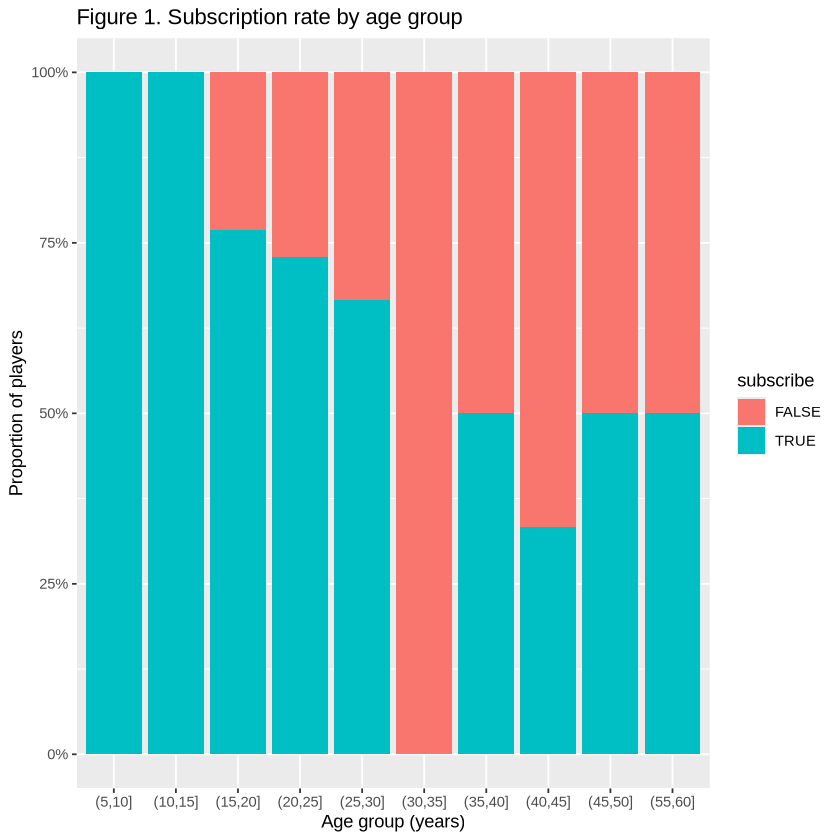

In [4]:
players_clean <- players |> filter(!is.na(subscribe))
p_age <- players_clean |>
  filter(!is.na(Age)) |>
  mutate(age_group = cut(Age, breaks = seq(5, 60, by = 5), right = TRUE)) |>
  ggplot(aes(x = age_group, fill = subscribe)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  labs(
    title = "Figure 1. Subscription rate by age group",
    x = "Age group (years)",
    y = "Proportion of players"
  )
p_age

In [5]:
players_age <- players |>
  filter(!is.na(Age),
         !is.na(subscribe)) |>
  mutate(subscribe = factor(subscribe,
                       levels = c(FALSE, TRUE),
                       labels = c("No", "Yes")))

In [6]:
players_age |>
  summarise(
    n = n(),
    mean_age = mean(Age),
    sd_age   = sd(Age)
  )

players_age |>
  count(subscribe)

n,mean_age,sd_age
<int>,<dbl>,<dbl>
194,21.13918,7.389687


subscribe,n
<fct>,<int>
No,52
Yes,142


In [7]:
set.seed(123)
players_split <- initial_split(players_age, prop = 0.8, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

nrow(players_train); nrow(players_test)

[1] 154

[1] 40

In [8]:
subscribe_recipe <- recipe(subscribe ~ Age, data = players_train) |>
  step_normalize(all_predictors())

subscribe_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 1



── Operations 

• Centering and scaling for: all_predictors()



In [9]:
knn_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors   = tune()
  ) |>
  set_engine("kknn") |>
  set_mode("classification")

set.seed(123)
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

players_wflow <- workflow() |>
  add_recipe(subscribe_recipe) |>
  add_model(knn_spec)

grid_k <- tibble(neighbors = seq(1, 51, by = 2))

set.seed(123)
knn_results <- players_wflow |>
  tune_grid(resamples = players_vfold,
            grid      = grid_k) |>
  collect_metrics()

knn_results |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean)) |>
  slice(1)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,accuracy,binary,0.7403091,5,0.0171395,Preprocessor1_Model13


In [10]:
best_k <- knn_results |>
  filter(.metric == "accuracy") |>
  slice_max(mean, n = 1) |>
  pull(neighbors)

best_k

[1] 25

In [11]:
final_knn_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors   = best_k
  ) |>
  set_engine("kknn") |>
  set_mode("classification")

final_wflow <- workflow() |>
  add_recipe(subscribe_recipe) |>
  add_model(final_knn_spec)

final_fit <- final_wflow |>
  fit(data = players_train)

In [12]:
test_pred <- predict(final_fit, players_test, type = "prob") |>
  bind_cols(
    predict(final_fit, players_test),   
    players_test |> select(subscribe, Age)
  )

head(test_pred)

.pred_No,.pred_Yes,.pred_class,subscribe,Age
<dbl>,<dbl>,<fct>,<fct>,<dbl>
0.44,0.56,Yes,Yes,17
0.44,0.56,Yes,No,17
0.20,0.80,Yes,No,21
0.44,0.56,Yes,Yes,17
0.48,0.52,Yes,Yes,58
0.60,0.40,No,No,18



# Discussion:
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to


# References

You may include references if necessary, as long as they all have a consistent citation style.